In [1]:
import pandas as pd

# Cargar el dataframe limpio desde el archivo pickle
df = pd.read_pickle('data_limpia.pkl')

# Ver las primeras filas para confirmar que se cargó correctamente
print(df.head())
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

    age  monthly_inhand_salary  num_bank_accounts  num_credit_card  \
0  23.0            1824.843333                3.0              4.0   
1  23.0            1426.204829                3.0              4.0   
2  40.8            2059.822083                3.0              4.0   
3  23.0            1661.386500                3.0              4.0   
4  23.0            1824.843333                3.0              4.0   

   interest_rate  delay_from_due_date  num_of_delayed_payment  \
0            3.0                    3                     7.0   
1            3.0                   -1                     7.6   
2            3.0                    3                     7.0   
3            3.0                    5                     4.0   
4            3.0                    6                     8.6   

   changed_credit_limit  num_credit_inquiries  outstanding_debt  ...  \
0                 11.27                   4.0            809.98  ...   
1                 11.27                   4.

## SMOTE + ADASYN

🔄 INICIANDO BALANCEO COMPLETO DE CLASES...
📊 DISTRIBUCIÓN DE CLASES ORIGINAL:
  Standard: 37222 muestras (53.2%)
  Poor: 20299 muestras (29.0%)
  Good: 12479 muestras (17.8%)

🔄 APLICANDO SMOTE...
📊 DISTRIBUCIÓN DE CLASES CON SMOTE:
  Standard: 37222 muestras (33.3%)
  Poor: 37222 muestras (33.3%)
  Good: 37222 muestras (33.3%)

🔄 APLICANDO ADASYN...
📊 DISTRIBUCIÓN DE CLASES CON ADASYN:
  Standard: 37222 muestras (33.9%)
  Poor: 32703 muestras (29.8%)
  Good: 39904 muestras (36.3%)

💾 Todos los datos balanceados guardados: 'balanced_data_complete.pkl'


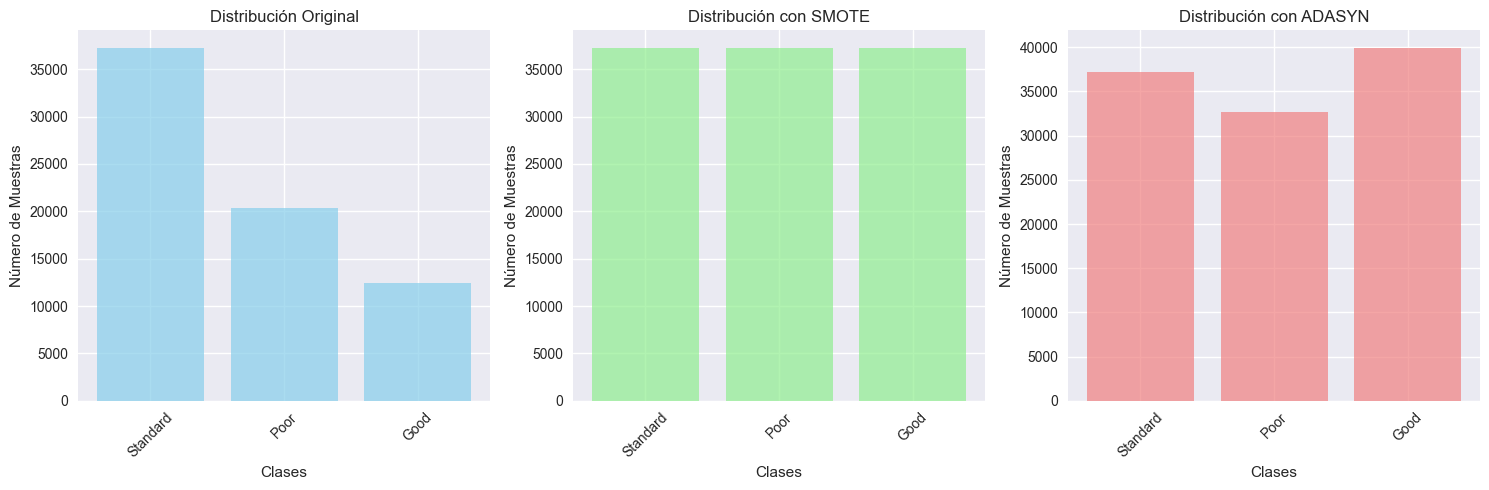

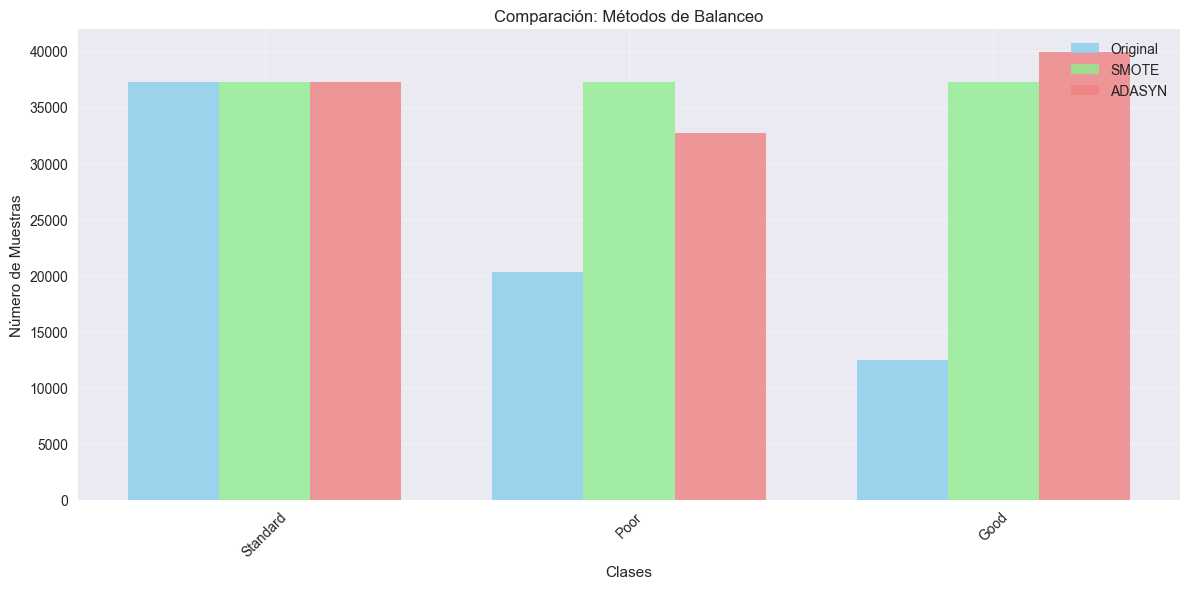


🎯 RESUMEN COMPLETO - BALANCEO DE CLASES
⏱️  Tiempo de ejecución: 5.93s

📊 ESTADÍSTICAS DEL DATASET:
  Muestras originales train: 70000
  Muestras con SMOTE: 111666
  Muestras con ADASYN: 109829
  Muestras test: 30000
  Características: 48
  Clases: 3

📈 INCREMENTO POR MÉTODO:
  SMOTE: +41666 muestras
  ADASYN: +39829 muestras

🔍 DIFERENCIAS ENTRE MÉTODOS:
  Standard:
    Original: 37222 | SMOTE: 37222 (+0) | ADASYN: 37222 (+0)
  Poor:
    Original: 20299 | SMOTE: 37222 (+16923) | ADASYN: 32703 (+12404)
  Good:
    Original: 12479 | SMOTE: 37222 (+24743) | ADASYN: 39904 (+27425)

💾 ARCHIVO GENERADO:
  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados

✅ USO EN MODELOS:
  from balanced_data_complete.pkl import:
    - X_train_smote, y_train_smote para entrenar con SMOTE
    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN
    - X_train_original, y_train_original para comparación


In [3]:
# BALANCEO DE CLASES COMPLETO - SMOTE + ADASYN
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

print("🔄 INICIANDO BALANCEO COMPLETO DE CLASES...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Seleccionamos las variables numericas a estandarizar
numerical_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categóricas a codificar
categorical_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas
binary_cols= ['not_specified','credit_builder_loan','personal_loan','debt_consolidation_loan'
            ,'student_loan', 'payday_loan','mortgage_loan','auto_loan','home_equity_loan']


# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("📊 DISTRIBUCIÓN DE CLASES ORIGINAL:")
class_dist_original = Counter(y_train_encoded)
for class_idx, count in class_dist_original.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_encoded)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR SMOTE
# =============================================================================

print("\n🔄 APLICANDO SMOTE...")

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("❌ Instalando imbalanced-learn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train_encoded)

print("📊 DISTRIBUCIÓN DE CLASES CON SMOTE:")
class_dist_smote = Counter(y_train_smote)
for class_idx, count in class_dist_smote.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_smote)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR ADASYN
# =============================================================================

print("\n🔄 APLICANDO ADASYN...")

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train_encoded)

print("📊 DISTRIBUCIÓN DE CLASES CON ADASYN:")
class_dist_adasyn = Counter(y_train_adasyn)
for class_idx, count in class_dist_adasyn.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_adasyn)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# GUARDAR DATOS BALANCEADOS EN UN SOLO ARCHIVO
# =============================================================================

balanced_data = {
    # Datos originales (para referencia)
    'X_train_original': X_train_processed,
    'y_train_original': y_train_encoded,
    
    # Datos con SMOTE
    'X_train_smote': X_train_smote,
    'y_train_smote': y_train_smote,
    
    # Datos con ADASYN
    'X_train_adasyn': X_train_adasyn,
    'y_train_adasyn': y_train_adasyn,
    
    # Datos de test (comunes para todos)
    'X_test_processed': X_test_processed,
    'y_test_encoded': y_test_encoded,
    
    # Preprocesadores y codificadores
    'preprocessor': preprocessor,
    'label_encoder': le,
    
    # Distribuciones
    'class_dist_original': class_dist_original,
    'class_dist_smote': class_dist_smote,
    'class_dist_adasyn': class_dist_adasyn,
    
    # Nombres de características
    'feature_names': (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))+
                binary_cols),
    
    # Información del dataset
    'dataset_info': {
        'original_samples': X_train_processed.shape[0],
        'smote_samples': X_train_smote.shape[0],
        'adasyn_samples': X_train_adasyn.shape[0],
        'test_samples': X_test_processed.shape[0],
        'n_features': X_train_processed.shape[1],
        'n_classes': len(le.classes_)
    }
}


joblib.dump(balanced_data, 'balanced_data_complete.pkl')

print(f"\n💾 Todos los datos balanceados guardados: 'balanced_data_complete.pkl'")

# =============================================================================
# VISUALIZACIÓN COMPARATIVA
# =============================================================================

plt.figure(figsize=(15, 5))

# Gráfico 1: Distribución original
plt.subplot(1, 3, 1)
classes_orig = [le.classes_[idx] for idx in class_dist_original.keys()]
counts_orig = list(class_dist_original.values())
plt.bar(classes_orig, counts_orig, color='skyblue', alpha=0.7)
plt.title('Distribución Original')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

# Gráfico 2: Distribución con SMOTE
plt.subplot(1, 3, 2)
classes_smote = [le.classes_[idx] for idx in class_dist_smote.keys()]
counts_smote = list(class_dist_smote.values())
plt.bar(classes_smote, counts_smote, color='lightgreen', alpha=0.7)
plt.title('Distribución con SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

# Gráfico 3: Distribución con ADASYN
plt.subplot(1, 3, 3)
classes_adasyn = [le.classes_[idx] for idx in class_dist_adasyn.keys()]
counts_adasyn = list(class_dist_adasyn.values())
plt.bar(classes_adasyn, counts_adasyn, color='lightcoral', alpha=0.7)
plt.title('Distribución con ADASYN')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN COMPARATIVO
# =============================================================================

plt.figure(figsize=(12, 6))

# Comparación lado a lado
x_pos = np.arange(len(classes_orig))
width = 0.25

plt.bar(x_pos - width, counts_orig, width, label='Original', alpha=0.8, color='skyblue')
plt.bar(x_pos, counts_smote, width, label='SMOTE', alpha=0.8, color='lightgreen')
plt.bar(x_pos + width, counts_adasyn[:len(classes_orig)], width, label='ADASYN', alpha=0.8, color='lightcoral')

plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Comparación: Métodos de Balanceo')
plt.xticks(x_pos, classes_orig, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*70)
print("🎯 RESUMEN COMPLETO - BALANCEO DE CLASES")
print("="*70)

print(f"⏱️  Tiempo de ejecución: {execution_time:.2f}s")

print(f"\n📊 ESTADÍSTICAS DEL DATASET:")
print(f"  Muestras originales train: {X_train_processed.shape[0]}")
print(f"  Muestras con SMOTE: {X_train_smote.shape[0]}")
print(f"  Muestras con ADASYN: {X_train_adasyn.shape[0]}")
print(f"  Muestras test: {X_test_processed.shape[0]}")
print(f"  Características: {X_train_processed.shape[1]}")
print(f"  Clases: {len(le.classes_)}")

print(f"\n📈 INCREMENTO POR MÉTODO:")
print(f"  SMOTE: +{X_train_smote.shape[0] - X_train_processed.shape[0]} muestras")
print(f"  ADASYN: +{X_train_adasyn.shape[0] - X_train_processed.shape[0]} muestras")

print(f"\n🔍 DIFERENCIAS ENTRE MÉTODOS:")
for class_idx in class_dist_original.keys():
    class_name = le.classes_[class_idx]
    orig = class_dist_original[class_idx]
    smote = class_dist_smote[class_idx]
    adasyn = class_dist_adasyn[class_idx]
    
    print(f"  {class_name}:")
    print(f"    Original: {orig} | SMOTE: {smote} (+{smote-orig}) | ADASYN: {adasyn} (+{adasyn-orig})")

print(f"\n💾 ARCHIVO GENERADO:")
print(f"  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados")

print(f"\n✅ USO EN MODELOS:")
print(f"  from balanced_data_complete.pkl import:")
print(f"    - X_train_smote, y_train_smote para entrenar con SMOTE")
print(f"    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN")
print(f"    - X_train_original, y_train_original para comparación")

print("="*70)

## K-Nearest Neighbors (KNN) Classifier

🚀 INICIANDO KNN - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO KNN CON DATOS ORIGINALES...
📊 MÉTRICAS KNN (DATOS ORIGINALES):
Accuracy : 0.7485
Precision (macro avg): 0.7251
Recall (macro avg): 0.7383
f1-Score (macro avg): 0.7311
CV Mean f1-score (macro avg): 0.7150
CV Std f1-score (macro avg): 0.0023

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.63      0.70      0.66      5349
        Poor       0.75      0.76      0.75      8699
    Standard       0.79      0.76      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000



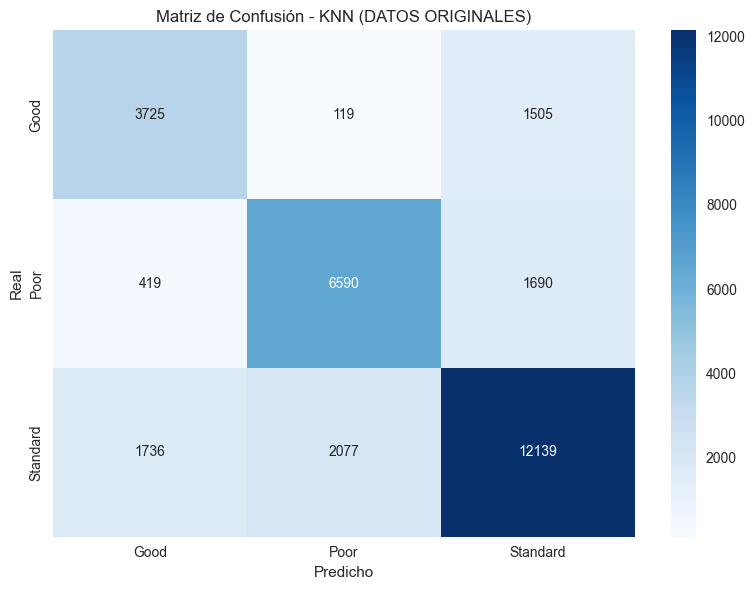


🎯 ENTRENANDO KNN CON SMOTE...
📊 MÉTRICAS KNN (SMOTE):
Accuracy : 0.7160
Precision (macro avg): 0.7038
Recall (macro avg): 0.7685
f1-Score (macro avg): 0.7117
CV Mean f1-score (macro avg): 0.8156
CV Std f1-score (macro avg): 0.0165

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.53      0.87      0.66      5349
        Poor       0.70      0.84      0.77      8699
    Standard       0.88      0.60      0.71     15952

    accuracy                           0.72     30000
   macro avg       0.70      0.77      0.71     30000
weighted avg       0.77      0.72      0.72     30000



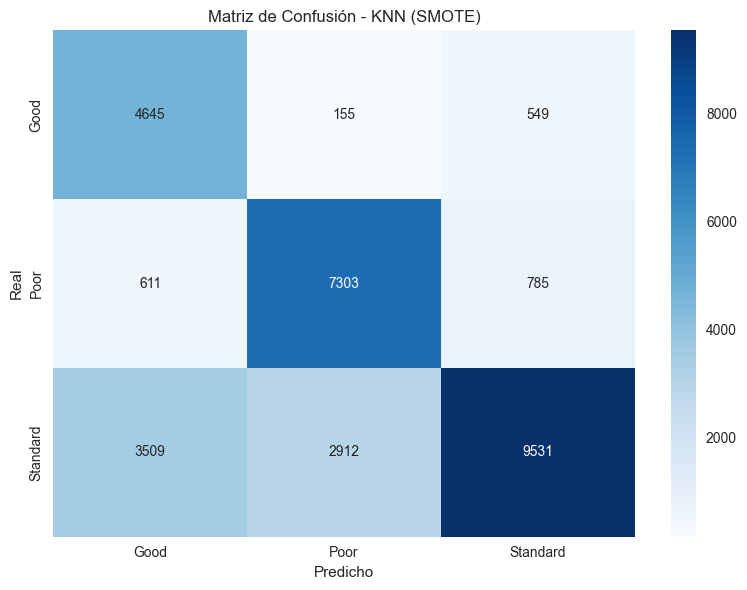


🎯 ENTRENANDO KNN CON ADASYN...
📊 MÉTRICAS KNN (ADASYN):
Accuracy : 0.7017
Precision (macro avg): 0.6990
Recall (macro avg): 0.7685
f1-Score (macro avg): 0.6997
CV Mean f1-score (macro avg): 0.7942
CV Std f1-score (macro avg): 0.0015

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.52      0.89      0.65      5349
        Poor       0.68      0.87      0.77      8699
    Standard       0.90      0.55      0.68     15952

    accuracy                           0.70     30000
   macro avg       0.70      0.77      0.70     30000
weighted avg       0.77      0.70      0.70     30000



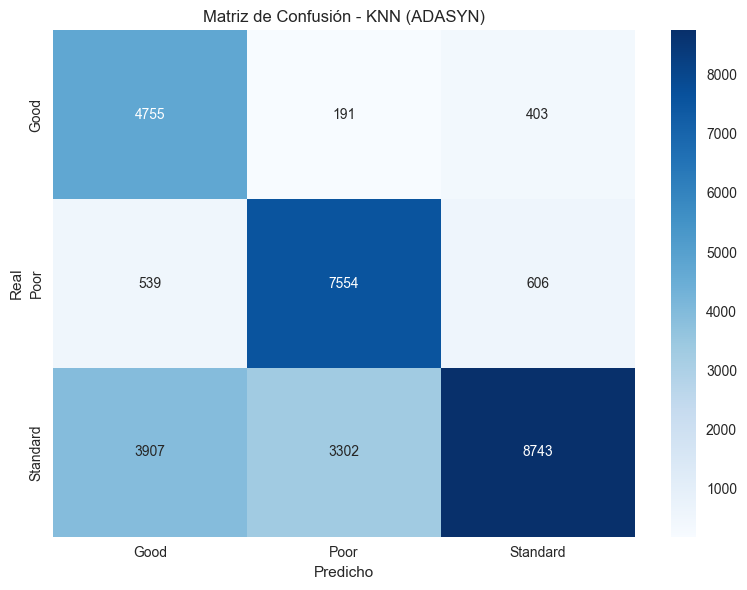


📊 COMPARACIÓN COMPLETA - KNN CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7485     0.7251  0.7383    0.7311   0.7150  0.0023   
1     SMOTE    0.7160     0.7038  0.7685    0.7117   0.8156  0.0165   
2    ADASYN    0.7017     0.6990  0.7685    0.6997   0.7942  0.0015   

   Tiempo (s)  
0      8.7052  
1     19.0260  
2     25.0670  


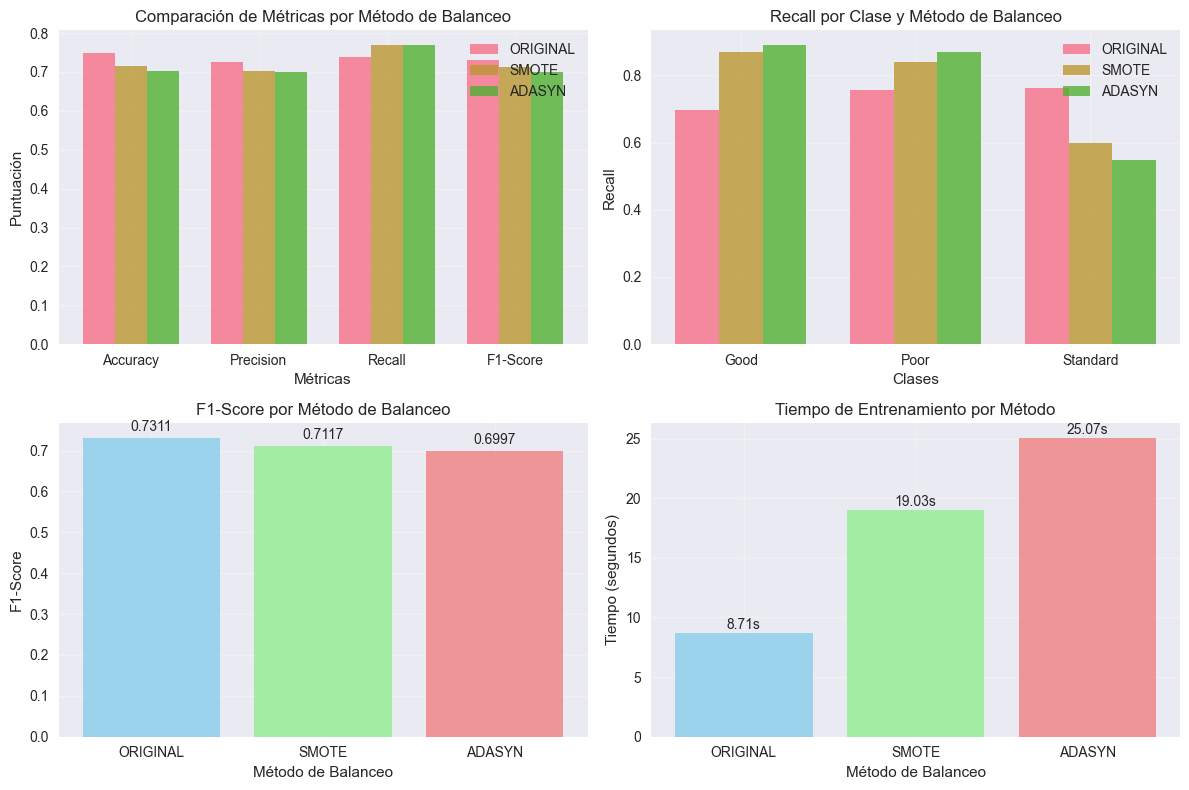


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:
📈 MEJORA EN RECALL:
   SMOTE vs Original: +0.0302
   ADASYN vs Original: +0.0302

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0194
   ADASYN vs Original: -0.0314

🎯 RESUMEN FINAL - KNN CON BALANCEO
⏱️  Tiempo total de ejecución: 53.83s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7485)
   Recall: ADASYN (0.7685)
   F1-Score: ORIGINAL (0.7311)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [ ]:
# =============================================================================
# KNN - COMPARACIÓN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO KNN - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR KNN
# =============================================================================

def entrenar_evaluar_knn(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\n🎯 ENTRENANDO KNN CON {nombre_conjunto}...")
    model_start = time.time()
    
    knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = knn_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS KNN ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"f1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    le = balanced_data['label_encoder']
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - KNN ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': knn_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

# Obtener datos de test (comunes para todos)
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Con datos originales (sin balanceo)
resultados['original'] = entrenar_evaluar_knn(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Con datos balanceados con SMOTE
resultados['smote'] = entrenar_evaluar_knn(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Con datos balanceados con ADASYN
resultados['adasyn'] = entrenar_evaluar_knn(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - KNN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Gráfico 1: Métricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase para cada método
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Comparación de F1-Score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[metodo.lower()]['f1'] for metodo in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[metodo.lower()]['execution_time'] for metodo in metodos]

plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - KNN CON BALANCEO")
print("="*80)

print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejor método por métrica
mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)

## Naive Bayes

🚀 INICIANDO NAIVE BAYES - COMPARACIÓN CON Y SIN BALANCEO...
Distribuciones train:
  Original: Counter({2: 37222, 1: 20299, 0: 12479})
  SMOTE   : Counter({2: 37222, 1: 37222, 0: 37222})
  ADASYN  : Counter({0: 39904, 2: 37222, 1: 32703})

🎯 ENTRENANDO NAIVE BAYES CON DATOS ORIGINALES...
📊 MÉTRICAS NB (DATOS ORIGINALES):
Accuracy : 0.6363
Precision (macro avg): 0.6342
Recall (macro avg): 0.6926
F1-Score (macro avg): 0.6324
CV Mean f1-score (macro avg): 0.6330
CV Std  f1-score (macro avg): 0.0054

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.46      0.84      0.59      5349
        Poor       0.61      0.71      0.66      8699
    Standard       0.83      0.53      0.65     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.69      0.63     30000
weighted avg       0.70      0.64      0.64     30000



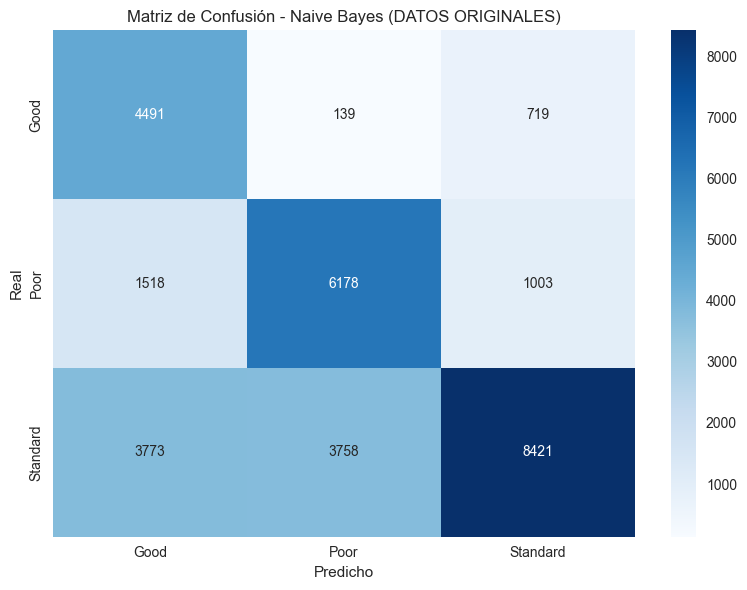


🎯 ENTRENANDO NAIVE BAYES CON SMOTE...
📊 MÉTRICAS NB (SMOTE):
Accuracy : 0.6205
Precision (macro avg): 0.6278
Recall (macro avg): 0.6873
F1-Score (macro avg): 0.6187
CV Mean f1-score (macro avg): 0.6835
CV Std  f1-score (macro avg): 0.0029

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.45      0.85      0.59      5349
        Poor       0.59      0.73      0.66      8699
    Standard       0.84      0.48      0.61     15952

    accuracy                           0.62     30000
   macro avg       0.63      0.69      0.62     30000
weighted avg       0.70      0.62      0.62     30000



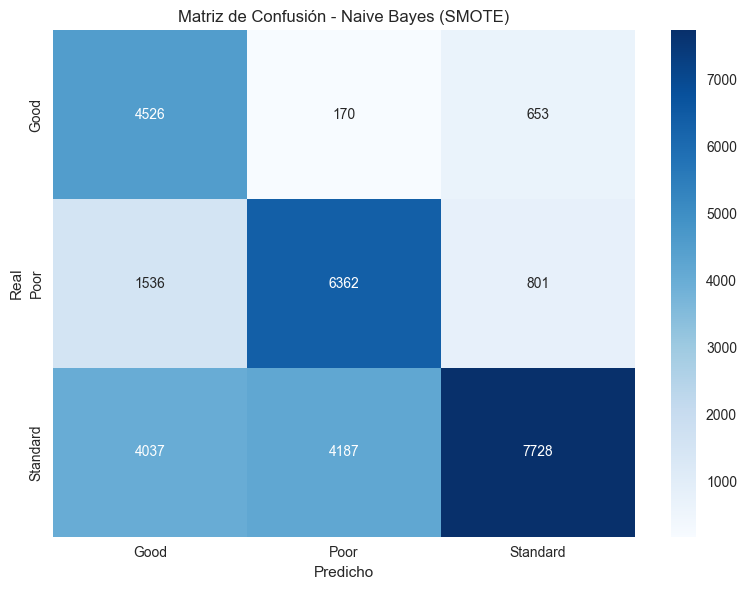


🎯 ENTRENANDO NAIVE BAYES CON ADASYN...
📊 MÉTRICAS NB (ADASYN):
Accuracy : 0.6089
Precision (macro avg): 0.6209
Recall (macro avg): 0.6794
F1-Score (macro avg): 0.6079
CV Mean f1-score (macro avg): 0.6258
CV Std  f1-score (macro avg): 0.0439

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.42      0.86      0.57      5349
        Poor       0.61      0.71      0.66      8699
    Standard       0.83      0.47      0.60     15952

    accuracy                           0.61     30000
   macro avg       0.62      0.68      0.61     30000
weighted avg       0.69      0.61      0.61     30000



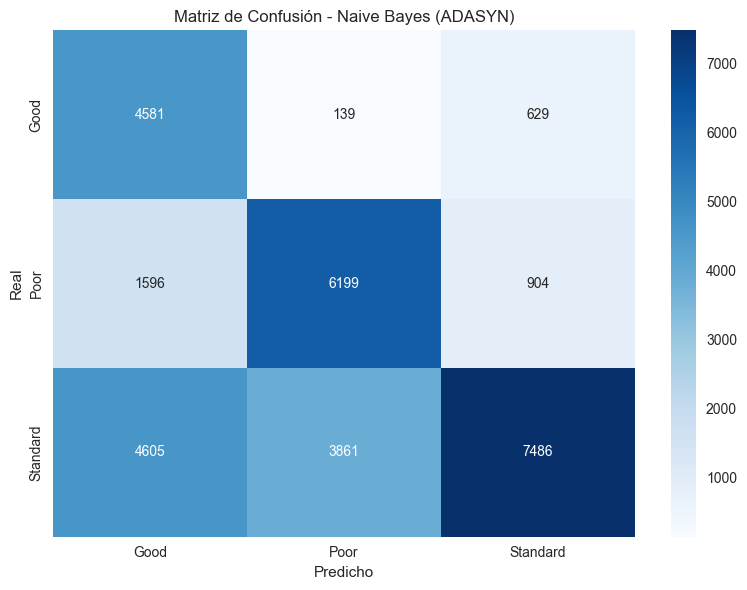


📊 COMPARACIÓN COMPLETA - NAIVE BAYES CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS (NB):
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.6363     0.6342  0.6926    0.6324   0.6330  0.0054   
1     SMOTE    0.6205     0.6278  0.6873    0.6187   0.6835  0.0029   
2    ADASYN    0.6089     0.6209  0.6794    0.6079   0.6258  0.0439   

   Tiempo (s)  
0      0.3757  
1      0.5885  
2      0.5665  


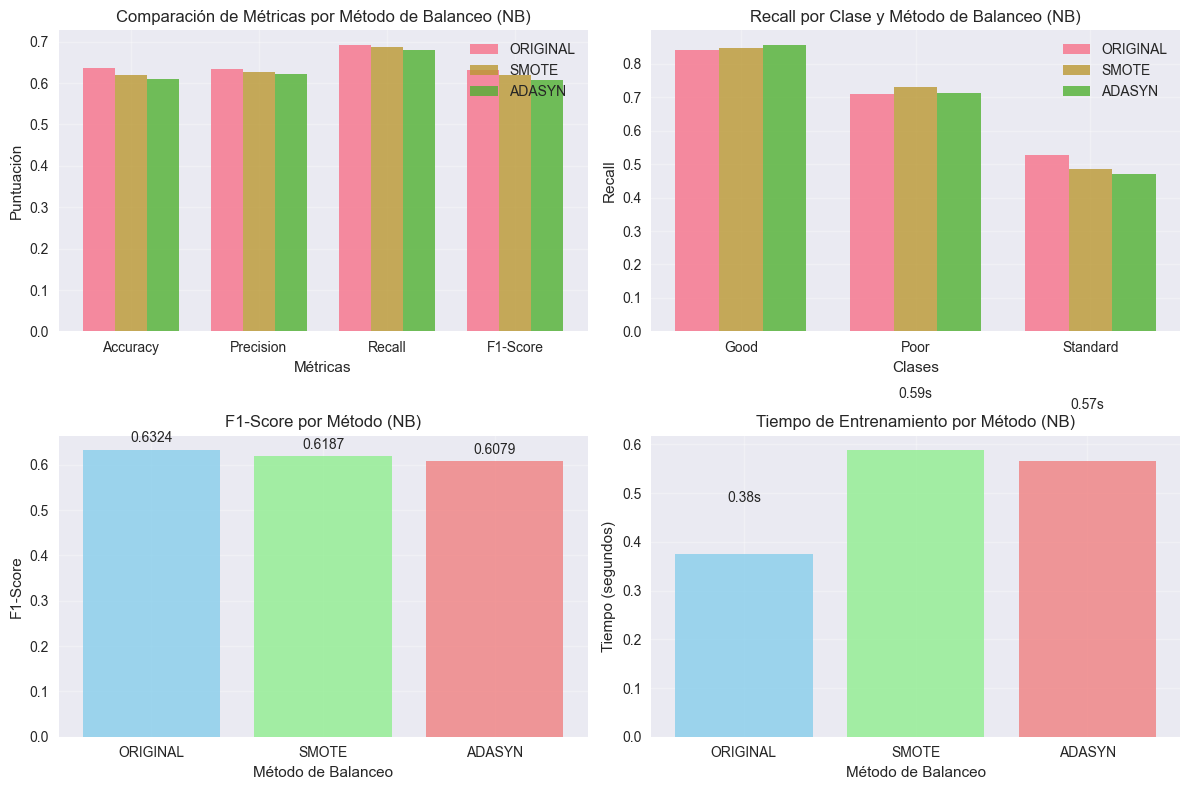


🔍 ANÁLISIS DE MEJORAS CON BALANCEO (NB):
📈 MEJORA EN RECALL:
   SMOTE vs Original: -0.0052
   ADASYN vs Original: -0.0131

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0137
   ADASYN vs Original: -0.0245

🎯 RESUMEN FINAL - NAIVE BAYES CON BALANCEO
⏱️  Tiempo total de ejecución: 2.56s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.6363)
   Recall:   ORIGINAL (0.6926)
   F1-Score: ORIGINAL (0.6324)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [10]:
# =============================================================================
# NAIVE BAYES - COMPARACIÓN CON Y SIN BALANCEO 
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO NAIVE BAYES - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados ya preprocesados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR NAIVE BAYES
# =============================================================================
def entrenar_evaluar_nb(X_train, y_train, X_test, y_test, nombre_conjunto, label_encoder):
    print(f"\n🎯 ENTRENANDO NAIVE BAYES CON {nombre_conjunto}...")
    model_start = time.time()

    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Predicciones
    y_pred = nb_model.predict(X_test)

    # Métricas principales (macro)
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall    = recall_score(y_test, y_pred, average='macro')
    f1        = f1_score(y_test, y_pred, average='macro')

    # Validación cruzada en train (F1 macro, k=5)
    cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='f1_macro')

    model_time = time.time() - model_start

    print(f"📊 MÉTRICAS NB ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std  f1-score (macro avg): {cv_scores.std():.4f}")

    # Reporte de clasificación (por clase)
    clases = label_encoder.classes_
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=clases))

    # Tabla por clase
    from sklearn.metrics import precision_recall_fscore_support
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=clases)

    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.title(f'Matriz de Confusión - Naive Bayes ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

    return {
        'model': nb_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON LOS TRES CONJUNTOS (Original / SMOTE / ADASYN)
# =============================================================================

# Test común
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

print("Distribuciones train:")
print("  Original:", Counter(balanced_data['y_train_original']))
print("  SMOTE   :", Counter(balanced_data['y_train_smote']))
print("  ADASYN  :", Counter(balanced_data['y_train_adasyn']))

resultados_nb = {}

# 1) Original (sin balanceo)
resultados_nb['original'] = entrenar_evaluar_nb(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES', le
)

# 2) SMOTE
resultados_nb['smote'] = entrenar_evaluar_nb(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE', le
)

# 3) ADASYN
resultados_nb['adasyn'] = entrenar_evaluar_nb(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN', le
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS 
# =============================================================================
print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - NAIVE BAYES CON DIFERENTES BALANCEOS")
print("="*80)

comparison_rows = []
for metodo, res in resultados_nb.items():
    comparison_rows.append({
        'Método': metodo.upper(),
        'Accuracy':  res['accuracy'],
        'Precision': res['precision'],
        'Recall':    res['recall'],
        'F1-Score':  res['f1'],
        'CV_Mean':   res['cv_mean'],
        'CV_Std':    res['cv_std'],
        'Tiempo (s)':res['execution_time']
    })
comparison_nb_df = pd.DataFrame(comparison_rows)
print("\n📈 COMPARACIÓN DE MÉTRICAS (NB):")
print(comparison_nb_df.round(4))

# =============================================================================
# GRÁFICOS COMPARATIVOS 
# =============================================================================
plt.figure(figsize=(12, 8))

# 1) Métricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    vals = [
        resultados_nb[metodo]['accuracy'],
        resultados_nb[metodo]['precision'],
        resultados_nb[metodo]['recall'],
        resultados_nb[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, vals, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo (NB)')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados_nb[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo (NB)')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# 3) F1 por método
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados_nb[m.lower()]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método (NB)')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 4) Tiempos
plt.subplot(2, 2, 4)
tiempos = [resultados_nb[m.lower()]['execution_time'] for m in metodos]
plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método (NB)')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================
print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO (NB):")
orig_rec = resultados_nb['original']['recall']
smot_rec = resultados_nb['smote']['recall']
ada_rec  = resultados_nb['adasyn']['recall']

orig_f1  = resultados_nb['original']['f1']
smot_f1  = resultados_nb['smote']['f1']
ada_f1   = resultados_nb['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smot_rec - orig_rec:+.4f}")
print(f"   ADASYN vs Original: {ada_rec - orig_rec:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smot_f1 - orig_f1:+.4f}")
print(f"   ADASYN vs Original: {ada_f1 - orig_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL + GUARDADO
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - NAIVE BAYES CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Mejor por métrica
mejor_acc  = max(resultados_nb.items(), key=lambda x: x[1]['accuracy'])
mejor_rec  = max(resultados_nb.items(), key=lambda x: x[1]['recall'])
mejor_f1   = max(resultados_nb.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_acc[0].upper()} ({mejor_acc[1]['accuracy']:.4f})")
print(f"   Recall:   {mejor_rec[0].upper()} ({mejor_rec[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")


##  Regresión Logística (con regularización L1 y L2)

🚀 INICIANDO REGRESIÓN LOGÍSTICA - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON DATOS ORIGINALES...
📊 MÉTRICAS (DATOS ORIGINALES):
Accuracy : 0.6492
Precision (macro avg): 0.6293
Recall (macro avg): 0.6134
F1-Score (macro avg): 0.6186
CV Mean f1-score (macro avg): 0.6207
CV Std f1-score (macro avg): 0.0032

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.55      0.57      0.56      5349
        Poor       0.66      0.53      0.59      8699
    Standard       0.68      0.74      0.71     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.61      0.62     30000
weighted avg       0.65      0.65      0.65     30000



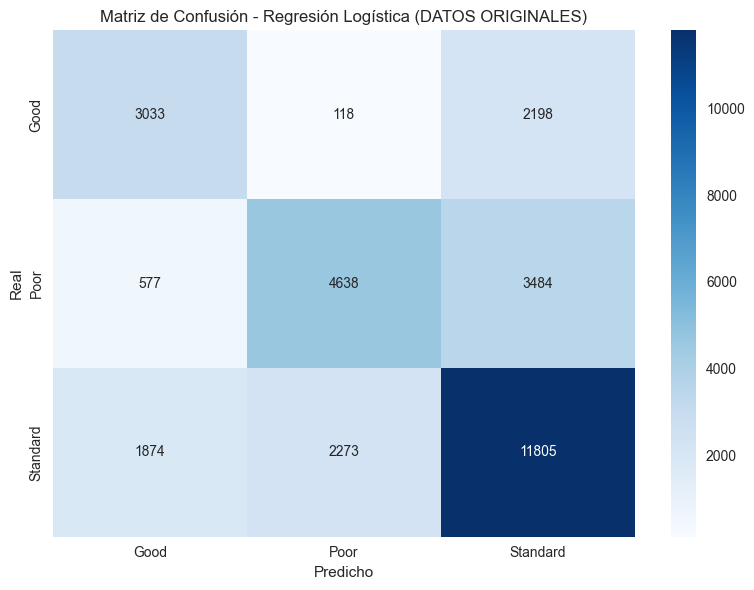


🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON SMOTE...
📊 MÉTRICAS (SMOTE):
Accuracy : 0.6480
Precision (macro avg): 0.6347
Recall (macro avg): 0.6889
F1-Score (macro avg): 0.6412
CV Mean f1-score (macro avg): 0.6920
CV Std f1-score (macro avg): 0.0026

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.48      0.81      0.60      5349
        Poor       0.63      0.68      0.65      8699
    Standard       0.80      0.58      0.67     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.69      0.64     30000
weighted avg       0.69      0.65      0.65     30000



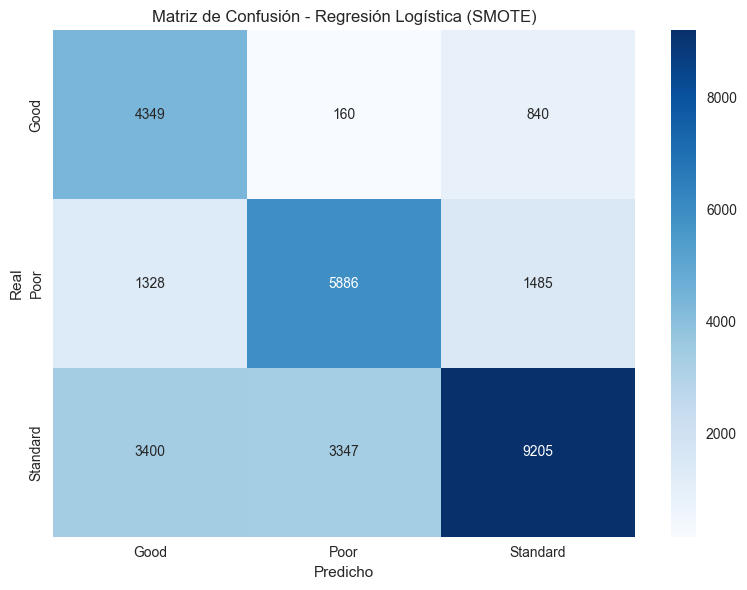


🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON ADASYN...
📊 MÉTRICAS (ADASYN):
Accuracy : 0.6369
Precision (macro avg): 0.6261
Recall (macro avg): 0.6797
F1-Score (macro avg): 0.6302
CV Mean f1-score (macro avg): 0.6288
CV Std f1-score (macro avg): 0.0464

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.46      0.82      0.59      5349
        Poor       0.63      0.65      0.64      8699
    Standard       0.79      0.57      0.66     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.68      0.63     30000
weighted avg       0.68      0.64      0.64     30000



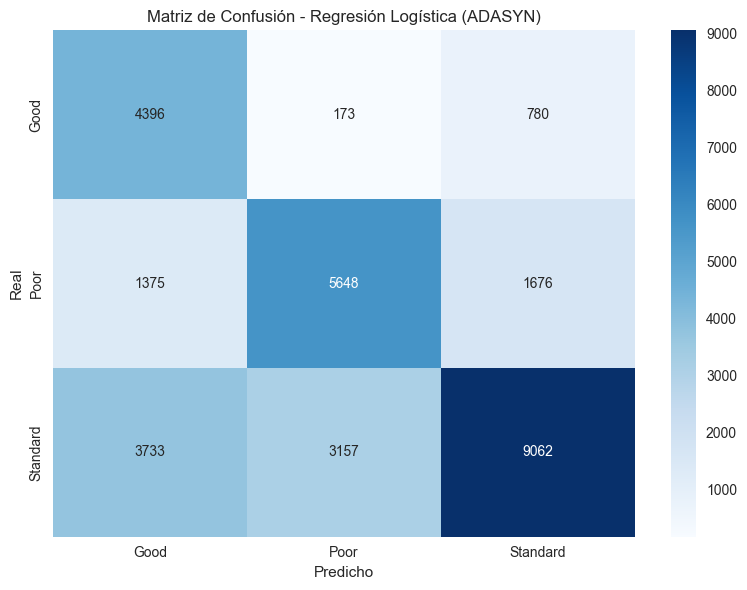


🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON CLASS_WEIGHT=balanced...
📊 MÉTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.6456
Precision (macro avg): 0.6344
Recall (macro avg): 0.6899
F1-Score (macro avg): 0.6394
CV Mean f1-score (macro avg): 0.6414
CV Std f1-score (macro avg): 0.0040

📋 REPORTE DE CLASIFICACIÓN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.47      0.82      0.60      5349
        Poor       0.63      0.68      0.65      8699
    Standard       0.80      0.57      0.67     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.69      0.64     30000
weighted avg       0.69      0.65      0.65     30000



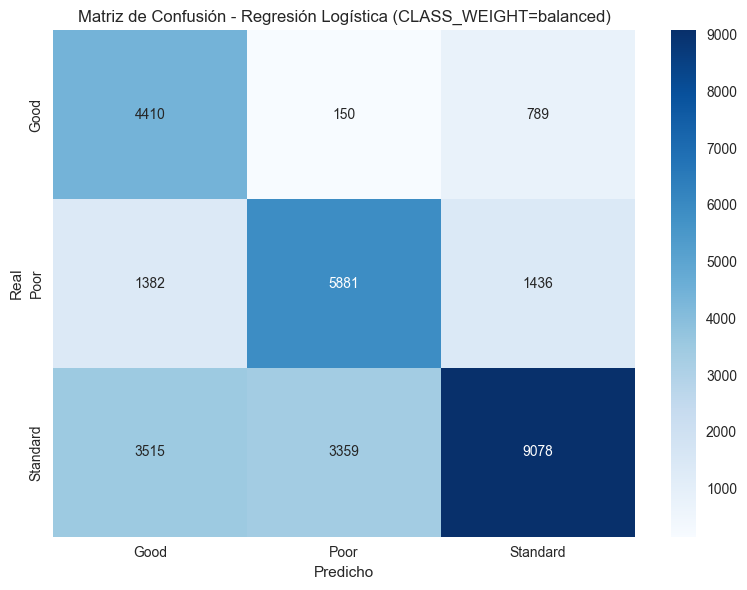


📊 COMPARACIÓN COMPLETA - REGRESIÓN LOGÍSTICA CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
         Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.6492     0.6293  0.6134    0.6186   0.6207  0.0032   
1         SMOTE    0.6480     0.6347  0.6889    0.6412   0.6920  0.0026   
2        ADASYN    0.6369     0.6261  0.6797    0.6302   0.6288  0.0464   
3  CLASS_WEIGHT    0.6456     0.6344  0.6899    0.6394   0.6414  0.0040   

   Tiempo (s)  
0     11.3440  
1     13.1794  
2     16.0885  
3     12.5923  


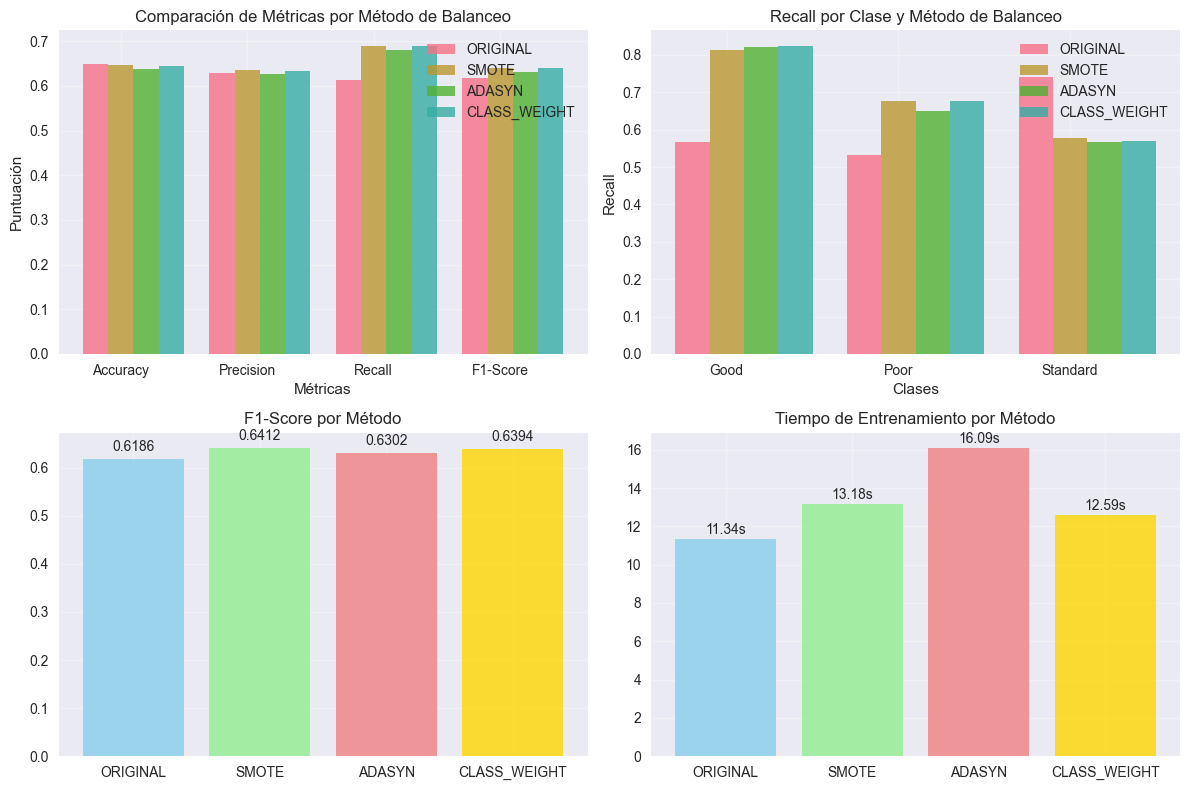


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:

📈 SMOTE vs Original:
   ▸ Mejora en F1-Score : +0.0226
   ▸ Mejora en Recall   : +0.0755

📈 ADASYN vs Original:
   ▸ Mejora en F1-Score : +0.0116
   ▸ Mejora en Recall   : +0.0663

📈 CLASS_WEIGHT vs Original:
   ▸ Mejora en F1-Score : +0.0208
   ▸ Mejora en Recall   : +0.0765

🎯 RESUMEN FINAL - REGRESIÓN LOGÍSTICA CON BALANCEO
⏱️  Tiempo total de ejecución: 54.50s

🏆 MEJOR MODELO SEGÚN F1-SCORE : SMOTE (0.6412)
🏆 MEJOR MODELO SEGÚN RECALL   : CLASS_WEIGHT (0.6899)

📊 RECOMENDACIÓN:
   ✅ Se recomienda usar SMOTE para mejor balance precisión-recall


In [5]:
# =============================================================================
# REGRESIÓN LOGÍSTICA - COMPARACIÓN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO REGRESIÓN LOGÍSTICA - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR REGRESIÓN LOGÍSTICA
# =============================================================================
def entrenar_evaluar_logreg(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\n🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON {nombre_conjunto}...")
    model_start = time.time()
    
    log_model = LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        class_weight=class_weight,
        n_jobs=-1
    )
    log_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = log_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - Regresión Logística ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': log_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_logreg(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_logreg(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_logreg(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_logreg(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - REGRESIÓN LOGÍSTICA CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gráfico de métricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por Método')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\n📈 {metodo.upper()} vs Original:")
    print(f"   ▸ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ▸ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - REGRESIÓN LOGÍSTICA CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejores modelos según F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\n🏆 MEJOR MODELO SEGÚN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"🏆 MEJOR MODELO SEGÚN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


## Árbol de Decisión

🚀 INICIANDO ÁRBOL DE DECISIÓN - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON DATOS ORIGINALES...
📊 MÉTRICAS (DATOS ORIGINALES):
Accuracy : 0.6721
Precision (macro avg): 0.6570
Recall (macro avg): 0.6777
F1-Score (macro avg): 0.6556
CV Mean f1-score (macro avg): 0.6578
CV Std f1-score (macro avg): 0.0036

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.50      0.76      0.60      5349
        Poor       0.74      0.59      0.65      8699
    Standard       0.74      0.69      0.71     15952

    accuracy                           0.67     30000
   macro avg       0.66      0.68      0.66     30000
weighted avg       0.69      0.67      0.68     30000



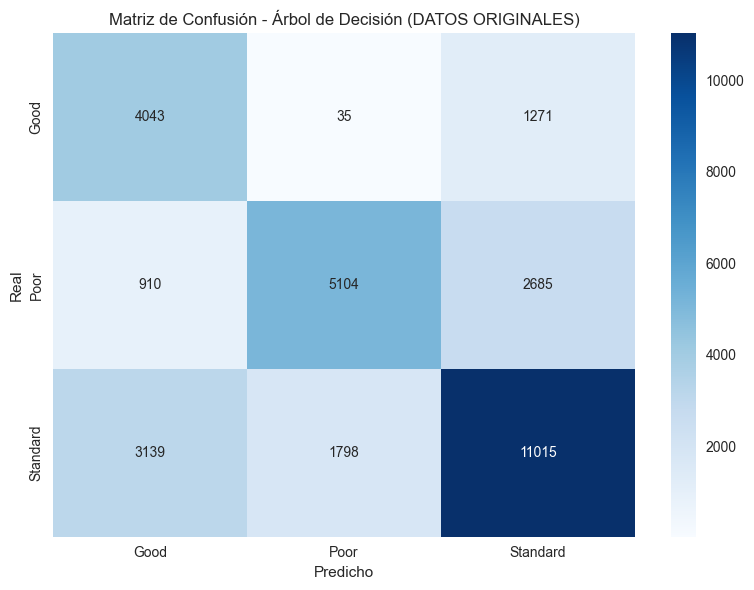


🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON SMOTE...
📊 MÉTRICAS (SMOTE):
Accuracy : 0.6509
Precision (macro avg): 0.6464
Recall (macro avg): 0.7055
F1-Score (macro avg): 0.6467
CV Mean f1-score (macro avg): 0.7103
CV Std f1-score (macro avg): 0.0065

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.48      0.82      0.60      5349
        Poor       0.62      0.76      0.68      8699
    Standard       0.84      0.53      0.65     15952

    accuracy                           0.65     30000
   macro avg       0.65      0.71      0.65     30000
weighted avg       0.71      0.65      0.65     30000



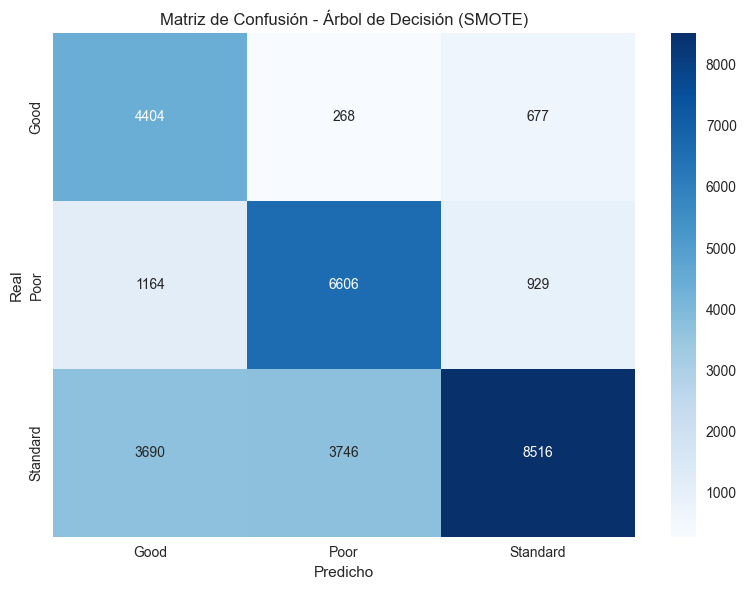


🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON ADASYN...
📊 MÉTRICAS (ADASYN):
Accuracy : 0.6756
Precision (macro avg): 0.6565
Recall (macro avg): 0.7030
F1-Score (macro avg): 0.6651
CV Mean f1-score (macro avg): 0.6658
CV Std f1-score (macro avg): 0.0334

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.50      0.80      0.62      5349
        Poor       0.68      0.67      0.67      8699
    Standard       0.79      0.64      0.71     15952

    accuracy                           0.68     30000
   macro avg       0.66      0.70      0.67     30000
weighted avg       0.71      0.68      0.68     30000



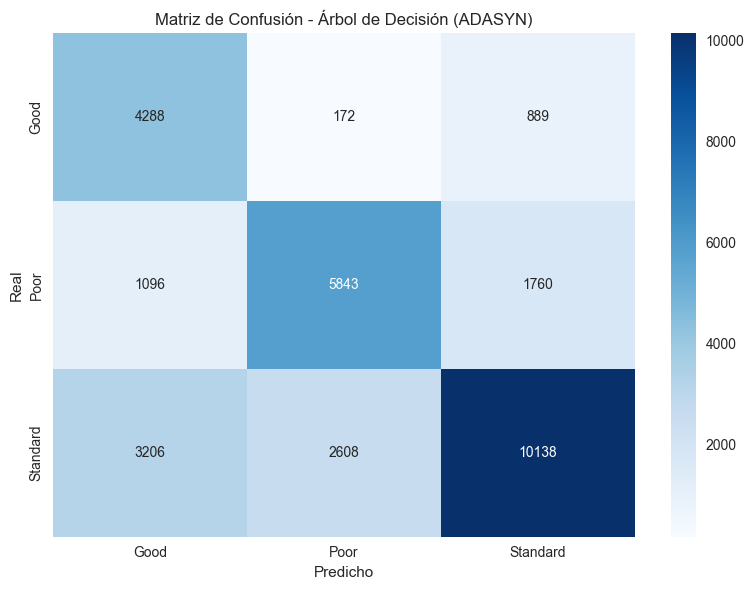


🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON CLASS_WEIGHT=balanced...
📊 MÉTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.6576
Precision (macro avg): 0.6488
Recall (macro avg): 0.7057
F1-Score (macro avg): 0.6517
CV Mean f1-score (macro avg): 0.6520
CV Std f1-score (macro avg): 0.0049

📋 REPORTE DE CLASIFICACIÓN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.48      0.83      0.60      5349
        Poor       0.63      0.73      0.68      8699
    Standard       0.84      0.56      0.67     15952

    accuracy                           0.66     30000
   macro avg       0.65      0.71      0.65     30000
weighted avg       0.71      0.66      0.66     30000



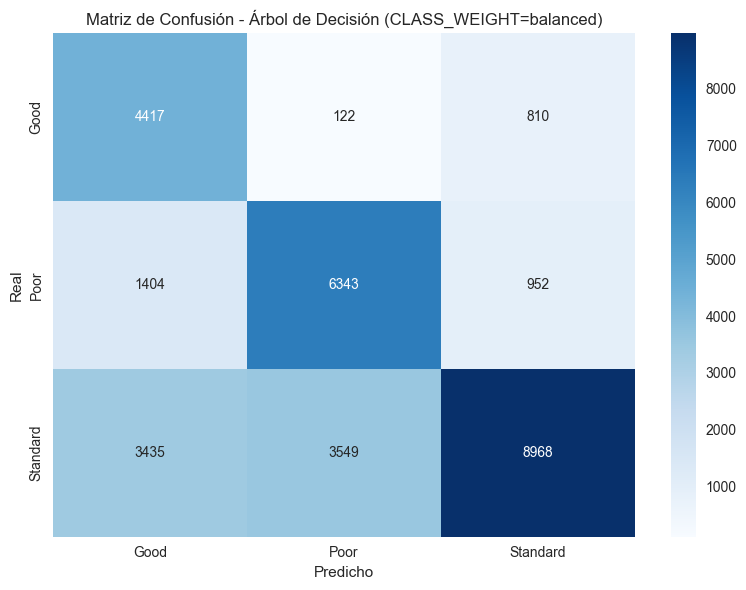


📊 COMPARACIÓN COMPLETA - ÁRBOL DE DECISIÓN CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
         Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.6721     0.6570  0.6777    0.6556   0.6578  0.0036   
1         SMOTE    0.6509     0.6464  0.7055    0.6467   0.7103  0.0065   
2        ADASYN    0.6756     0.6565  0.7030    0.6651   0.6658  0.0334   
3  CLASS_WEIGHT    0.6576     0.6488  0.7057    0.6517   0.6520  0.0049   

   Tiempo (s)  
0      3.0884  
1      9.1951  
2      8.2629  
3      3.9288  


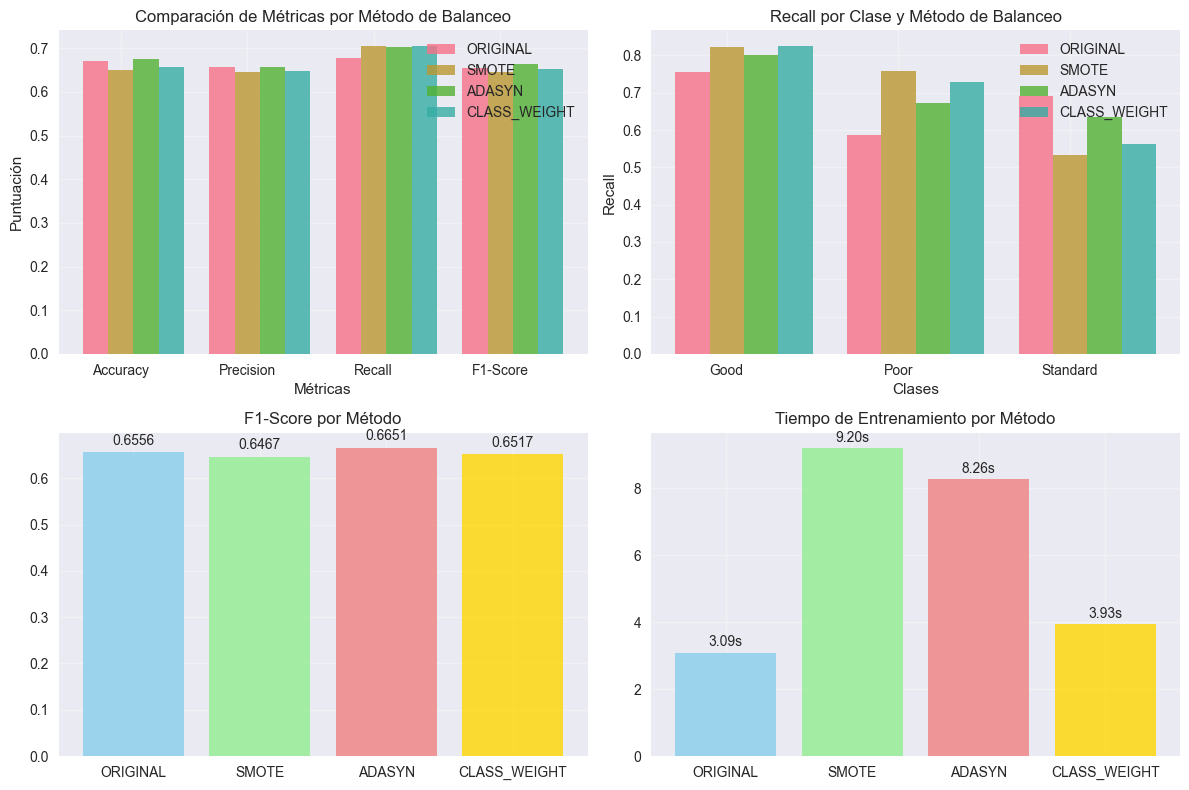


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:

📈 SMOTE vs Original:
   ▸ Mejora en F1-Score : -0.0089
   ▸ Mejora en Recall   : +0.0278

📈 ADASYN vs Original:
   ▸ Mejora en F1-Score : +0.0095
   ▸ Mejora en Recall   : +0.0253

📈 CLASS_WEIGHT vs Original:
   ▸ Mejora en F1-Score : -0.0040
   ▸ Mejora en Recall   : +0.0280

🎯 RESUMEN FINAL - ÁRBOL DE DECISIÓN CON BALANCEO
⏱️  Tiempo total de ejecución: 25.92s

🏆 MEJOR MODELO SEGÚN F1-SCORE : ADASYN (0.6651)
🏆 MEJOR MODELO SEGÚN RECALL   : CLASS_WEIGHT (0.7057)

📊 RECOMENDACIÓN:
   ✅ Se recomienda usar ADASYN para mejor balance precisión-recall


In [7]:
# =============================================================================
# ÁRBOL DE DECISIÓN - COMPARACIÓN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO ÁRBOL DE DECISIÓN - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR ÁRBOL DE DECISIÓN
# =============================================================================
def entrenar_evaluar_arbol(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\n🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON {nombre_conjunto}...")
    model_start = time.time()
    
    tree_model = DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight,
        max_depth=5
    )
    tree_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = tree_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - Árbol de Decisión ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': tree_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_arbol(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_arbol(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_arbol(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_arbol(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - ÁRBOL DE DECISIÓN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gráfico de métricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por Método')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\n📈 {metodo.upper()} vs Original:")
    print(f"   ▸ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ▸ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - ÁRBOL DE DECISIÓN CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejores modelos según F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\n🏆 MEJOR MODELO SEGÚN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"🏆 MEJOR MODELO SEGÚN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


## Random Forest

🚀 INICIANDO RANDOM FOREST - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO RANDOM FOREST CON DATOS ORIGINALES...
📊 MÉTRICAS (DATOS ORIGINALES):
Accuracy : 0.7827
Precision (macro avg): 0.7685
Recall (macro avg): 0.7695
F1-Score (macro avg): 0.7690
CV Mean f1-score (macro avg): 0.7580
CV Std f1-score (macro avg): 0.0045

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.72      0.72      0.72      5349
        Poor       0.78      0.79      0.78      8699
    Standard       0.81      0.80      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



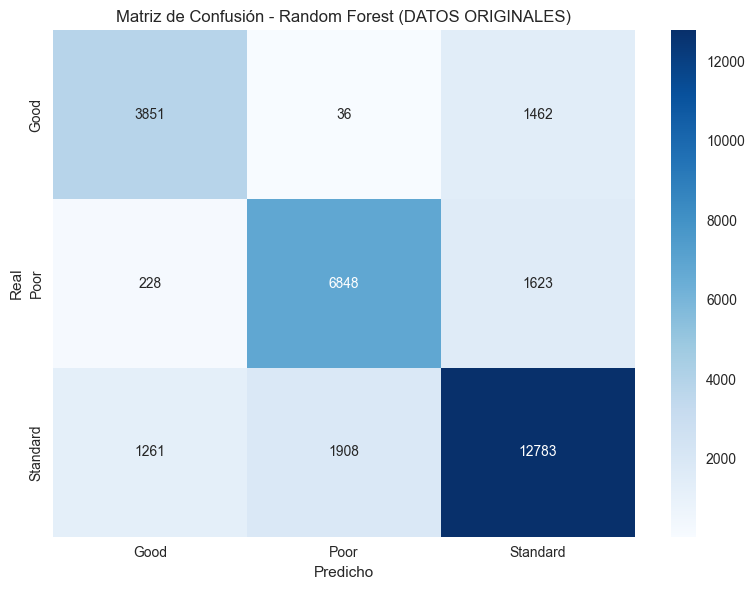


🎯 ENTRENANDO RANDOM FOREST CON SMOTE...
📊 MÉTRICAS (SMOTE):
Accuracy : 0.7722
Precision (macro avg): 0.7488
Recall (macro avg): 0.7767
F1-Score (macro avg): 0.7604
CV Mean f1-score (macro avg): 0.8425
CV Std f1-score (macro avg): 0.0281

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.65      0.78      0.71      5349
        Poor       0.76      0.80      0.78      8699
    Standard       0.83      0.76      0.79     15952

    accuracy                           0.77     30000
   macro avg       0.75      0.78      0.76     30000
weighted avg       0.78      0.77      0.77     30000



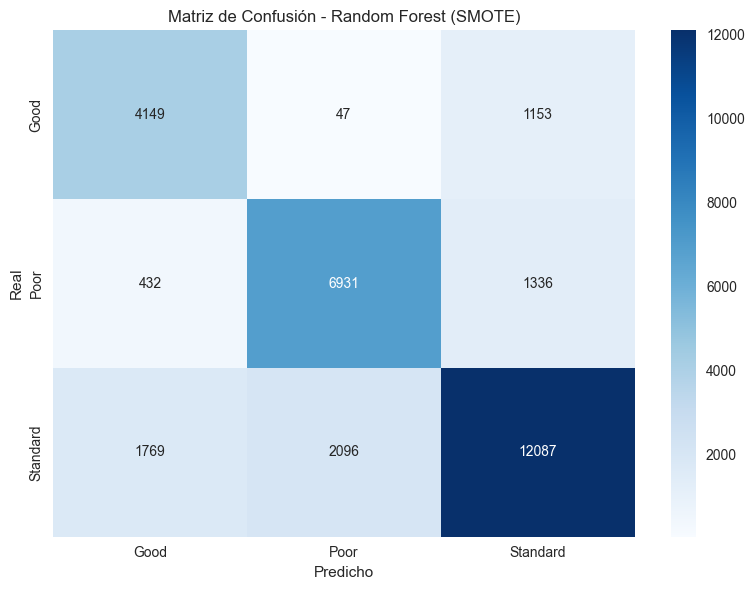


🎯 ENTRENANDO RANDOM FOREST CON ADASYN...
📊 MÉTRICAS (ADASYN):
Accuracy : 0.7797
Precision (macro avg): 0.7567
Recall (macro avg): 0.7860
F1-Score (macro avg): 0.7688
CV Mean f1-score (macro avg): 0.8350
CV Std f1-score (macro avg): 0.0117

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.67      0.79      0.72      5349
        Poor       0.77      0.81      0.79      8699
    Standard       0.84      0.76      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.76      0.79      0.77     30000
weighted avg       0.79      0.78      0.78     30000



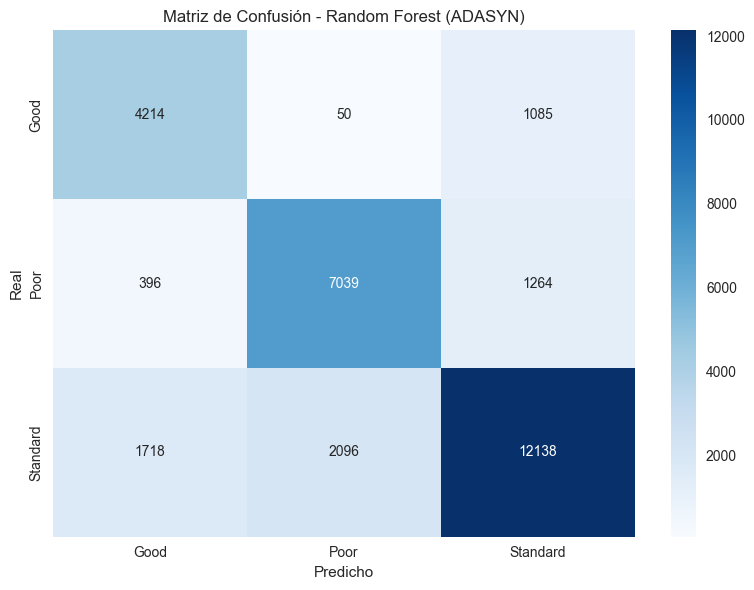


🎯 ENTRENANDO RANDOM FOREST CON CLASS_WEIGHT=balanced...
📊 MÉTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.7835
Precision (macro avg): 0.7714
Recall (macro avg): 0.7671
F1-Score (macro avg): 0.7692
CV Mean f1-score (macro avg): 0.7566
CV Std f1-score (macro avg): 0.0042

📋 REPORTE DE CLASIFICACIÓN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.73      0.71      0.72      5349
        Poor       0.78      0.78      0.78      8699
    Standard       0.80      0.81      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



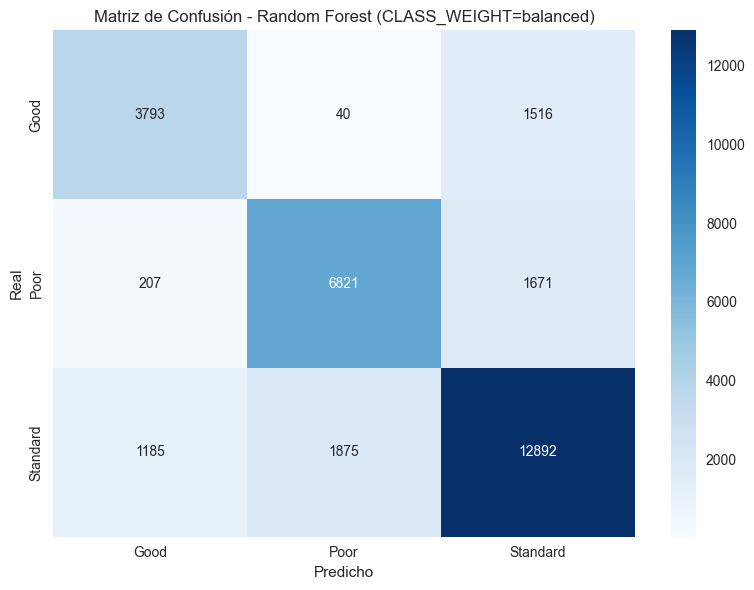


📊 COMPARACIÓN COMPLETA - RANDOM FOREST CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
         Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.7827     0.7685  0.7695    0.7690   0.7580  0.0045   
1         SMOTE    0.7722     0.7488  0.7767    0.7604   0.8425  0.0281   
2        ADASYN    0.7797     0.7567  0.7860    0.7688   0.8350  0.0117   
3  CLASS_WEIGHT    0.7835     0.7714  0.7671    0.7692   0.7566  0.0042   

   Tiempo (s)  
0     20.0757  
1     60.2185  
2     62.8846  
3     29.6117  


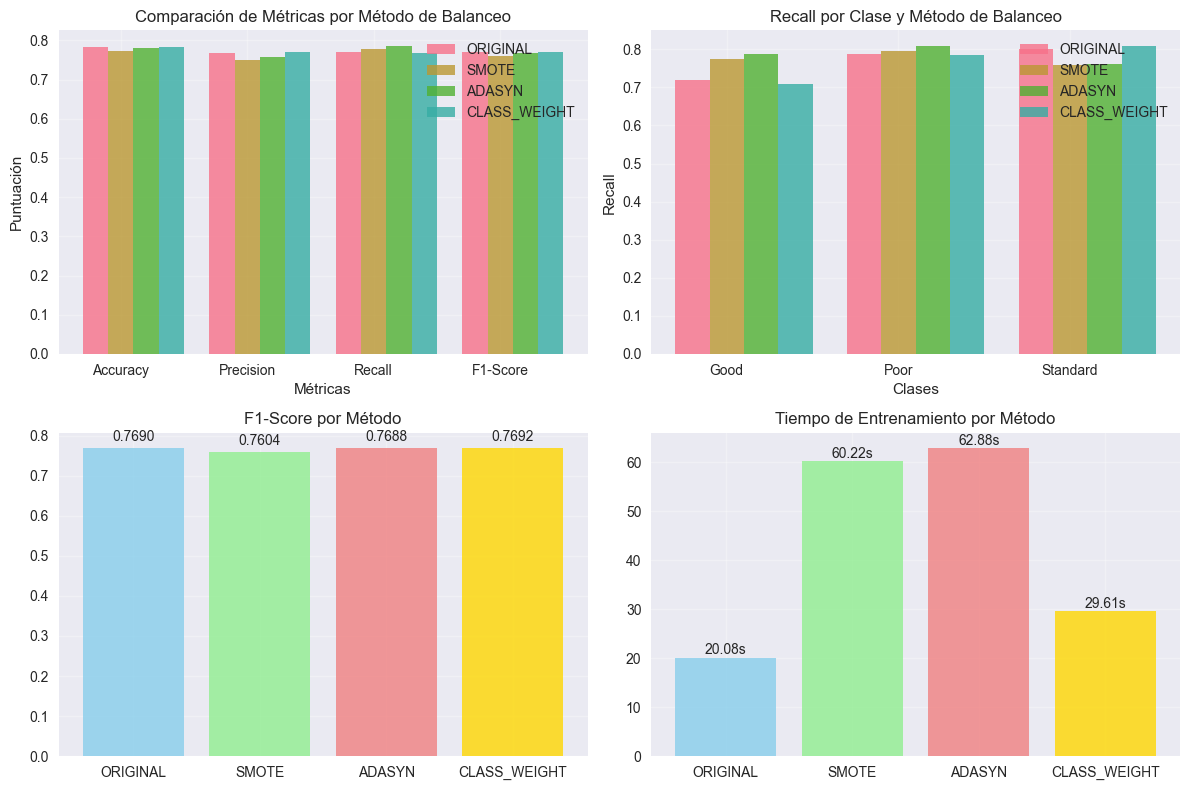


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:

📈 SMOTE vs Original:
   ▸ Mejora en F1-Score : -0.0086
   ▸ Mejora en Recall   : +0.0072

📈 ADASYN vs Original:
   ▸ Mejora en F1-Score : -0.0002
   ▸ Mejora en Recall   : +0.0165

📈 CLASS_WEIGHT vs Original:
   ▸ Mejora en F1-Score : +0.0002
   ▸ Mejora en Recall   : -0.0024

🎯 RESUMEN FINAL - RANDOM FOREST CON BALANCEO
⏱️  Tiempo total de ejecución: 174.25s

🏆 MEJOR MODELO SEGÚN F1-SCORE : CLASS_WEIGHT (0.7692)
🏆 MEJOR MODELO SEGÚN RECALL   : ADASYN (0.7860)

📊 RECOMENDACIÓN:
   ✅ Se recomienda usar CLASS_WEIGHT para mejor balance precisión-recall


In [8]:
# =============================================================================
# RANDOM FOREST - COMPARACIÓN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO RANDOM FOREST - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR RANDOM FOREST
# =============================================================================
def entrenar_evaluar_rf(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\n🎯 ENTRENANDO RANDOM FOREST CON {nombre_conjunto}...")
    model_start = time.time()
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight
    )
    rf_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = rf_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - Random Forest ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': rf_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_rf(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_rf(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_rf(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_rf(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - RANDOM FOREST CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gráfico de métricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por Método')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\n📈 {metodo.upper()} vs Original:")
    print(f"   ▸ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ▸ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - RANDOM FOREST CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejores modelos según F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\n🏆 MEJOR MODELO SEGÚN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"🏆 MEJOR MODELO SEGÚN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


## XGBoost (con interpretabilidad usando LIME)

🚀 INICIANDO XGBOOST - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO XGBOOST CON DATOS ORIGINALES...
📊 MÉTRICAS XGBOOST (DATOS ORIGINALES):
Accuracy : 0.7515
Precision (macro avg): 0.7340
Recall (macro avg): 0.7350
F1-Score (macro avg): 0.7344
CV Mean F1-Score: 0.7304
CV Std F1-Score: 0.0041

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.67      0.69      0.68      5349
        Poor       0.75      0.73      0.74      8699
    Standard       0.78      0.78      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000



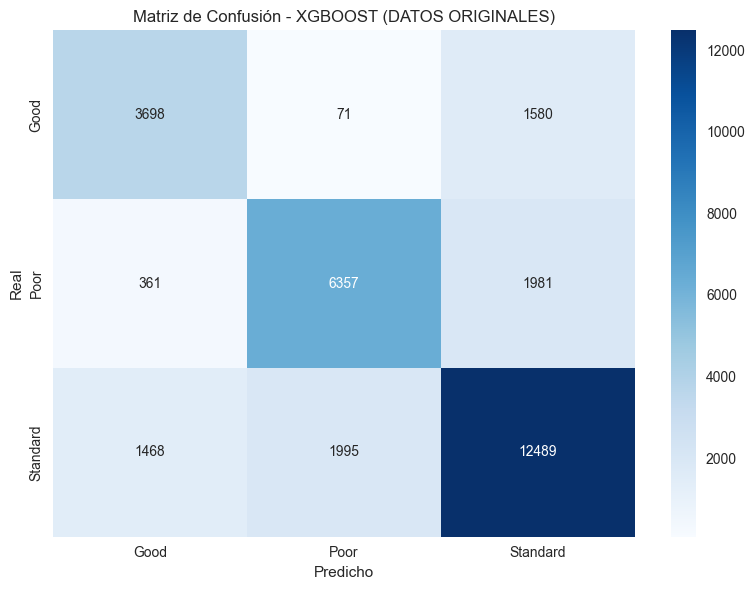


🎯 ENTRENANDO XGBOOST CON SMOTE...
📊 MÉTRICAS XGBOOST (SMOTE):
Accuracy : 0.7437
Precision (macro avg): 0.7223
Recall (macro avg): 0.7360
F1-Score (macro avg): 0.7283
CV Mean F1-Score: 0.7978
CV Std F1-Score: 0.0647

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.64      0.72      0.67      5349
        Poor       0.74      0.73      0.74      8699
    Standard       0.78      0.76      0.77     15952

    accuracy                           0.74     30000
   macro avg       0.72      0.74      0.73     30000
weighted avg       0.75      0.74      0.74     30000



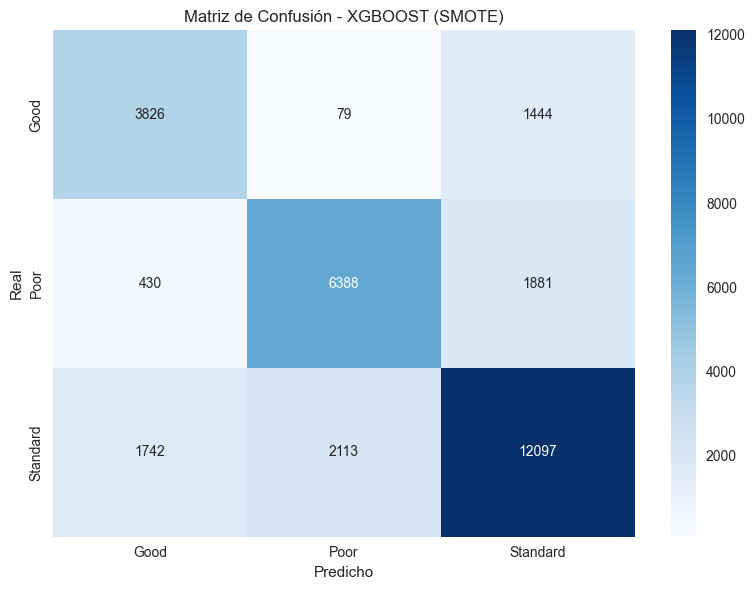


🎯 ENTRENANDO XGBOOST CON ADASYN...
📊 MÉTRICAS XGBOOST (ADASYN):
Accuracy : 0.7403
Precision (macro avg): 0.7202
Recall (macro avg): 0.7319
F1-Score (macro avg): 0.7254
CV Mean F1-Score: 0.7695
CV Std F1-Score: 0.0487

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.64      0.71      0.68      5349
        Poor       0.74      0.72      0.73      8699
    Standard       0.78      0.76      0.77     15952

    accuracy                           0.74     30000
   macro avg       0.72      0.73      0.73     30000
weighted avg       0.74      0.74      0.74     30000



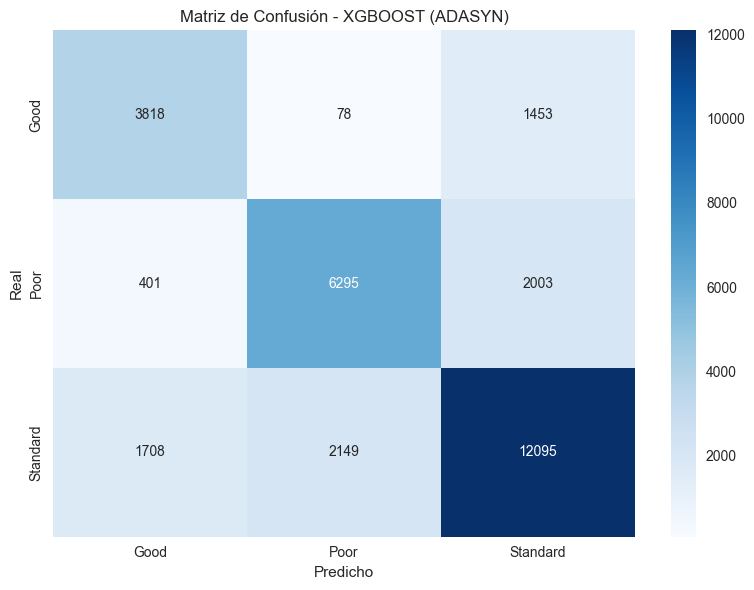


📊 COMPARACIÓN COMPLETA - XGBOOST CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7515     0.7340  0.7350    0.7344   0.7304  0.0041   
1     SMOTE    0.7437     0.7223  0.7360    0.7283   0.7978  0.0647   
2    ADASYN    0.7403     0.7202  0.7319    0.7254   0.7695  0.0487   

   Tiempo (s)  
0      5.1976  
1     16.4498  
2     21.7823  


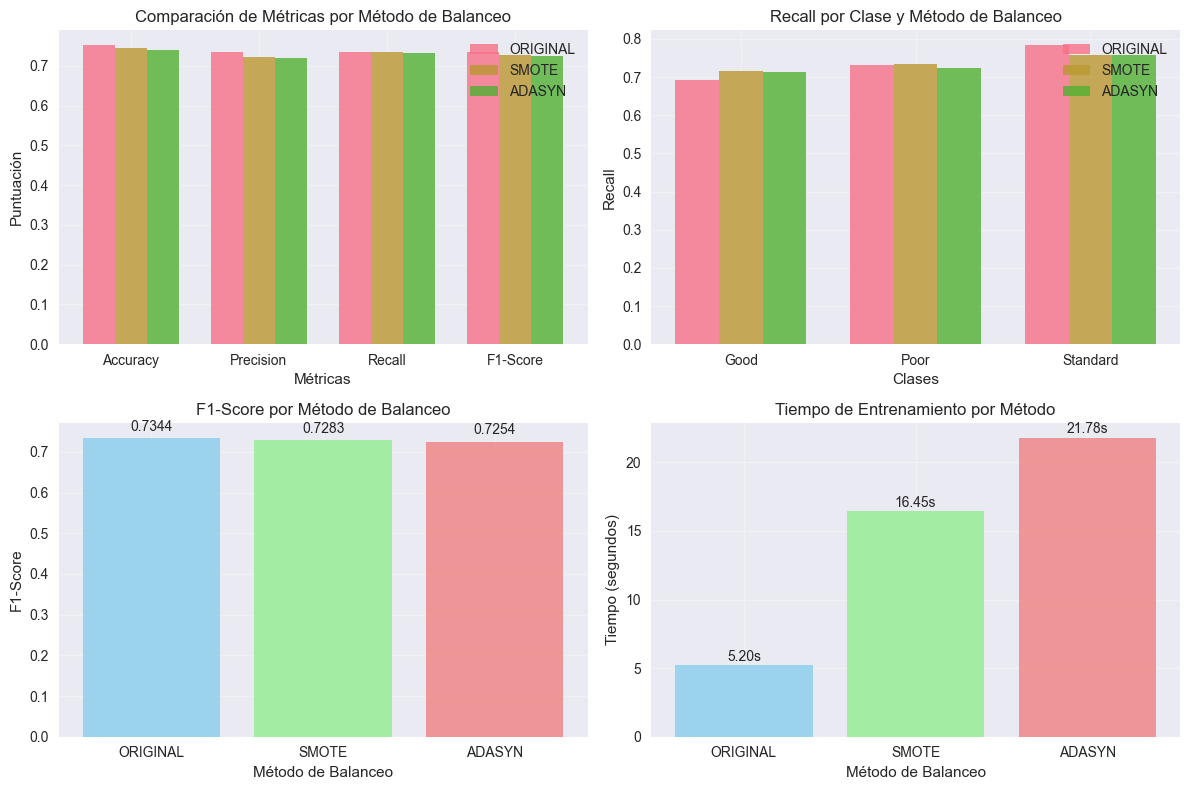


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:
📈 MEJORA EN RECALL:
   SMOTE vs Original: +0.0010
   ADASYN vs Original: -0.0031

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0061
   ADASYN vs Original: -0.0090

🎯 RESUMEN FINAL - XGBOOST CON BALANCEO
⏱️  Tiempo total de ejecución: 44.65s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7515)
   Recall: SMOTE (0.7360)
   F1-Score: ORIGINAL (0.7344)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [9]:
# =============================================================================
# XGBOOST - COMPARACIÓN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO XGBOOST - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados (debes tener el archivo generado previamente)
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR XGBOOST
# =============================================================================

def entrenar_evaluar_xgb(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\n🎯 ENTRENANDO XGBOOST CON {nombre_conjunto}...")
    model_start = time.time()
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = xgb_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS XGBOOST ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean F1-Score: {cv_scores.mean():.4f}")
    print(f"CV Std F1-Score: {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - XGBOOST ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': xgb_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Original
resultados['original'] = entrenar_evaluar_xgb(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. SMOTE
resultados['smote'] = entrenar_evaluar_xgb(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. ADASYN
resultados['adasyn'] = entrenar_evaluar_xgb(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - XGBOOST CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# Gráficos
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

# 1. Gráfico de métricas generales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. F1-score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[m.lower()]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 4. Tiempos
plt.subplot(2, 2, 4)
tiempos = [resultados[m.lower()]['execution_time'] for m in metodos]
plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - XGBOOST CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


## Máquina de Soporte Vectorial

🚀 INICIANDO MAQUÍNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO 

📈 EVALUANDO MODELO DE MÁQUINA DE VECTORES DE SOPORTE...

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.57      0.67      0.62      5349
        Poor       0.74      0.63      0.68      8699
    Standard       0.74      0.76      0.75     15952

    accuracy                           0.70     30000
   macro avg       0.68      0.69      0.68     30000
weighted avg       0.71      0.70      0.70     30000



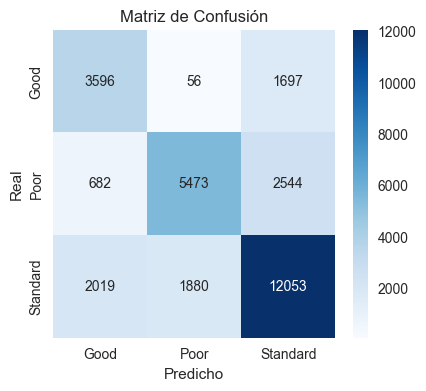


🔍 ANÁLISIS DE ERRORES POR CLASE:
Accuracy por clase:
  Good: 0.6723 (67.23%)
  Poor: 0.6292 (62.92%)
  Standard: 0.7556 (75.56%)

🎯 RESUMEN FINAL - MÁQUINA DE VECTORES DE SOPORTE BENCHMARK
⏱️  Tiempo ejecución: 446.70s

🎯 EVALUACIÓN: ⚠️  ACEPTABLE

💾 Resultados guardados: 'svm_benchmark_results.pkl'


In [ ]:
# =============================================================================
# MÁQUINA DE SOPORTE VECTORIAL - MODELO BENCHMARK
# =============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO MAQUÍNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================


# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

y = y.map({
    'Good': 0,
    'Poor': 1,
    'Standard': 2
    
})


# Seleccionamos las variables numericas a estandarizar
num_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categóricas a codificar
cat_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas


# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Codificación de categóricas
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Estandarización de numéricas
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Combinar numéricas y categóricas
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])



print(f"✅ Datos preparados: {X_train_final.shape[0]} train, {X_test_final.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO 
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO ")

svm=SVC()
svm.fit(X_train_final,y_train)

# Predicciones
y_pred = svm.predict(X_test_final)


# =============================================================================
# EVALUACIÓN COMPLETA
# =============================================================================

print("\n📈 EVALUANDO MODELO DE MÁQUINA DE VECTORES DE SOPORTE...")

# Métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Poor', 'Standard']))

# =============================================================================
# VISUALIZACIONES 
# =============================================================================

# Matriz de confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title(f'Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# =============================================================================
# ANÁLISIS DE ERRORES POR CLASE
# =============================================================================

print("\n🔍 ANÁLISIS DE ERRORES POR CLASE:")

# Calcular accuracy por clase
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("Accuracy por clase:")
for i, cls in enumerate(['Good', 'Poor', 'Standard']):
    print(f"  {cls}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time


print("\n" + "="*60)
print("🎯 RESUMEN FINAL - MÁQUINA DE VECTORES DE SOPORTE BENCHMARK")
print("="*60)
print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")

# Evaluación cualitativa
if f1 > 0.8:
    performance = "🌟 EXCELENTE"
elif f1 > 0.7:
    performance = "✅ BUENO"
elif f1 > 0.6:
    performance = "⚠️  ACEPTABLE"
else:
    performance = "❌ MEJORABLE"

print(f"\n🎯 EVALUACIÓN: {performance}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'SVM',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'performance': performance
}

joblib.dump(benchmark_data, 'svm_benchmark_results.pkl')
print(f"\n💾 Resultados guardados: 'svm_benchmark_results.pkl'")

print("="*60)